In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
# read in all the words
words = open('../lecture 2/names.txt').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [18]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g) 
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 #scaling W2 down at init to prevent first iter logits from being too high
b2 = torch.randn(vocab_size,                      generator=g) * 0 #setting b2 to be 0 at initialization to prevent first iter logits from going nuts


parameters = [C, W1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11697


In [21]:
#Dame optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    #minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    Xb,Yb = Xtr[ix], Ytr[ix] #batch X,Y
    #Forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0],-1) #concatenate the vectors 
    hpreact = embcat @ W1 + b1 #hidden layer preactivation
    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2 #output layer 
    loss = F.cross_entropy(logits,Yb)

    #Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update 
    lr = 0.1 if i < 100000 else 0.01 #step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    #track stats 
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


      0/ 200000: 3.1857
  10000/ 200000: 1.8734
  20000/ 200000: 1.9344
  30000/ 200000: 2.0513
  40000/ 200000: 2.2272
  50000/ 200000: 2.1511
  60000/ 200000: 2.1176
  70000/ 200000: 2.8093
  80000/ 200000: 2.6944
  90000/ 200000: 2.2984
 100000/ 200000: 2.2699
 110000/ 200000: 1.8550
 120000/ 200000: 2.1641
 130000/ 200000: 1.9782
 140000/ 200000: 1.8181
 150000/ 200000: 2.4424
 160000/ 200000: 2.2711
 170000/ 200000: 1.8003
 180000/ 200000: 1.9056
 190000/ 200000: 2.1542


In [22]:
#Now our loss doesn't look like a hockey stick. we're reducing initial loss

In [ ]:
logits[0] #these are the logits at the very first iteration of our training loop that gave us 27 loss. these should be much much much closer to 0

tensor([ -2.3527,  36.4366, -10.7306,   5.7165,  18.6409, -11.6998,  -2.1991,
          1.8535,  10.9996,  10.6730,  12.3507, -10.3809,   4.7243, -24.4257,
         -8.5909,   1.9024, -12.2744, -12.4751, -23.2778,  -2.0163,  25.8767,
         14.2108,  17.7691, -10.9204, -20.7335,   6.4560,  11.1615],
       grad_fn=<SelectBackward0>)

In [ ]:
logits[0] #better!

tensor([-0.0249,  0.3523, -0.1267,  0.0541,  0.1662, -0.1171, -0.0140,  0.0124,
         0.0921,  0.1135,  0.1362, -0.0925,  0.0444, -0.2459, -0.0971,  0.0125,
        -0.0957, -0.1376, -0.2329, -0.0137,  0.2452,  0.1616,  0.1665, -0.1094,
        -0.2154,  0.0725,  0.1141], grad_fn=<SelectBackward0>)

In [ ]:
#initialization loss is wayyyyy too high. since we expect a uniform distribution of letters in the beginning where they're each most likely, we expect the loss to be:
-torch.tensor(1/27.0).log() #27 is way higher than 3.29.

tensor(3.2958)

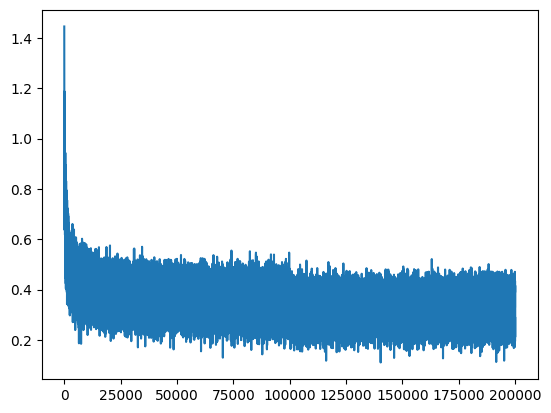

In [8]:
plt.plot(lossi)

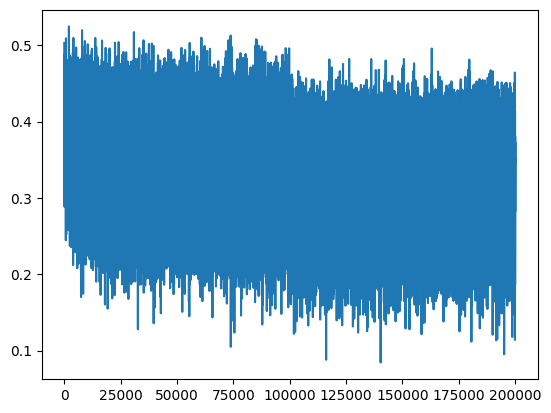

In [23]:
#old loss above before fixing
#new loss below after fixing
plt.plot(lossi)

In [9]:
@torch.no_grad() #disable gradient tracking. 
def split_loss(split):
    x,y = {
        'train': (Xtr,Ytr),
        'val': (Xdev,Ydev),
        'test': (Xte,Yte)
    }[split]
    emb = C[x]#(N, block_size, n_embd)
    embcat = emb.view(emb.shape[0],-1) #concatenate into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1) # (N, Nhidden)
    logits = h @ W2 + b2 # (N, vocab_size) 
    loss = F.cross_entropy(logits,y)
    print(split,loss.item())

split_loss('train')
split_loss('val')


train 2.1269264221191406
val 2.171828031539917


In [10]:
#sample from model 
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # init with all
    while True:
        #Forward pass the NN
        emb = C[torch.tensor([context])] # (1, block_size, n_embd)
        h = torch.tanh(emb.view(1,-1) @ W1+b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim = 1)
        #sample from dist
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        #shift the context window and track samples
        context = context[1:]+ [ix]
        out.append(ix)
        #if we sample the special "." token, break
        if ix == 0:
            break
    print(''.join(itos[i]for i in out))

carmah.
amelle.
khy.
mili.
taty.
skanden.
jazonte.
den.
art.
kaqaif.
ramari.
chaiivia.
legy.
dham.
jocca.
dint.
salin.
alianni.
waztho.
dearixi.


In [ ]:
#----------------------------------------------------------------------------- SEGMENT 1 DONE, SHOWING HOW TO FIX INITIAL LOSS VALUES; FRESH CODE BELOW

In [24]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g) 
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 #scaling W2 down at init to prevent first iter logits from being too high
b2 = torch.randn(vocab_size,                      generator=g) * 0 #setting b2 to be 0 at initialization to prevent first iter logits from going nuts


parameters = [C, W1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11697


In [25]:
#Dame optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    #minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    Xb,Yb = Xtr[ix], Ytr[ix] #batch X,Y
    #Forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0],-1) #concatenate the vectors 
    hpreact = embcat @ W1 + b1 #hidden layer preactivation
    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2 #output layer 
    loss = F.cross_entropy(logits,Yb)

    #Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update 
    lr = 0.1 if i < 100000 else 0.01 #step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    #track stats 
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break


      0/ 200000: 3.3221


In [ ]:
#The logits are now okay, now we got problems with the values of h. We see lots of 1's and -1's. Its a squashing function
h

tensor([[ 0.8100, -0.8997, -0.9993,  ..., -0.9097, -1.0000,  1.0000],
        [-1.0000, -0.9571, -0.7145,  ...,  0.4898,  0.9090,  0.9937],
        [ 0.9983, -0.3340,  1.0000,  ...,  0.9443,  0.9905,  1.0000],
        ...,
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000],
        [-1.0000, -0.4385, -0.8882,  ..., -0.3316,  0.9995,  1.0000],
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000]],
       grad_fn=<TanhBackward0>)

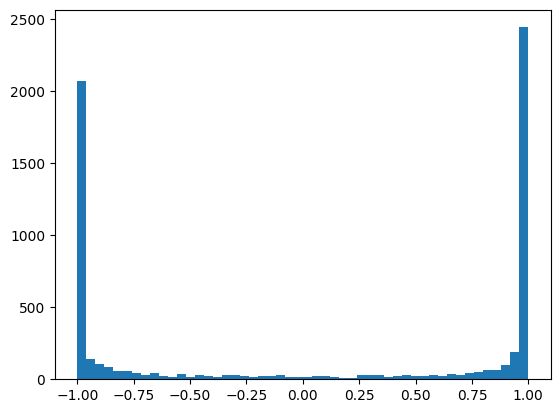

In [30]:
plt.hist(h.view(-1).tolist(),50);

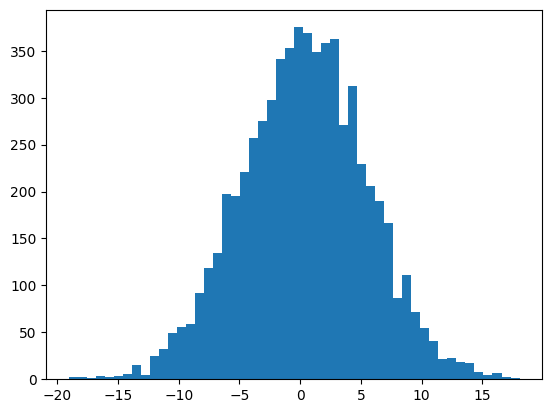

In [31]:
plt.hist(hpreact.view(-1).tolist(),50);

In [ ]:
# These distributions are too saturated. 
# because we're calculating the gradients backwards through tanh, if the input values are -1 or 1, the gradient adjustment will be killed; on an elementwise level
# tanh's gradient is calculated  like so (1-t^2) * out.grad. if t takes a val of -1 or 1, the whole thing becomes 0 and we kill the gradient.
#the weights and biases connected to this tanh will not contribute to the loss because tanh is "stuck" in a very flat area in the tanh surface. 

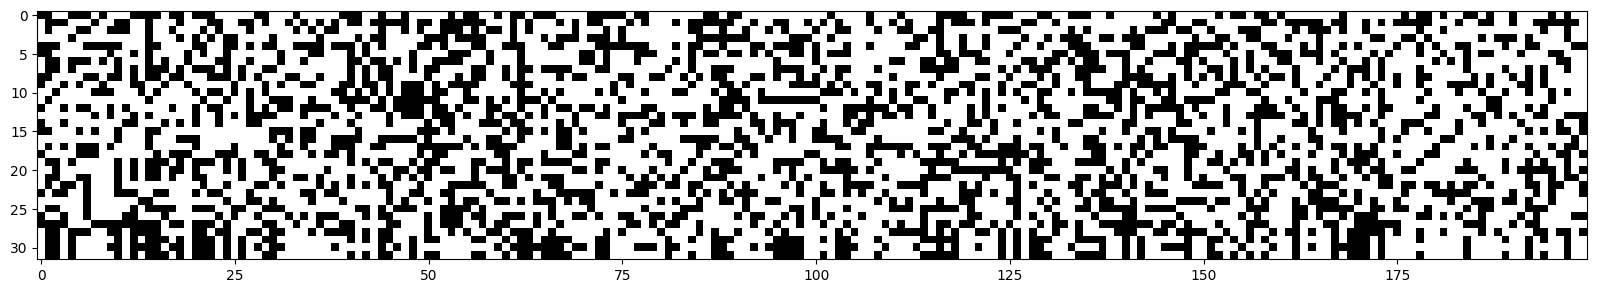

In [ ]:
#Every neuron associated with this "stuck" tanh is like a dead neuron, it doesn't learn, it doesn't contribute to the loss. if any of the columns in the below graph are 
#all white, then not a single example ever activates that neuron, and that's not great. Thankfully that's not the case here.
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99, cmap="gray", interpolation="nearest")

In [ ]:
#Let's fix it! Reinit everything. We want Hpreact to be closer to 0. Its made of a neuron activation with embcat and w1 and b1, and the problem is that hpreact is too far 
#away from 0. So we make W1 and B1 smaller. 

In [40]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 #scaling W2 down at init to prevent first iter logits from being too high
b2 = torch.randn(vocab_size,                      generator=g) * 0 #setting b2 to be 0 at initialization to prevent first iter logits from going nuts


parameters = [C, W1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11697


In [45]:
#Dame optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    #minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    Xb,Yb = Xtr[ix], Ytr[ix] #batch X,Y
    #Forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0],-1) #concatenate the vectors 
    hpreact = embcat @ W1 + b1 #hidden layer preactivation
    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2 #output layer 
    loss = F.cross_entropy(logits,Yb)

    #Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update 
    lr = 0.1 if i < 100000 else 0.01 #step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    #track stats 
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    #break


      0/ 200000: 3.2466
  10000/ 200000: 1.9222
  20000/ 200000: 1.8991
  30000/ 200000: 1.9745
  40000/ 200000: 2.0871
  50000/ 200000: 1.9749
  60000/ 200000: 2.0796
  70000/ 200000: 2.3772
  80000/ 200000: 2.5110
  90000/ 200000: 2.1863
 100000/ 200000: 2.2270
 110000/ 200000: 1.8214
 120000/ 200000: 2.2077
 130000/ 200000: 1.9776
 140000/ 200000: 1.7861
 150000/ 200000: 2.3862
 160000/ 200000: 2.0314
 170000/ 200000: 1.6659
 180000/ 200000: 1.8944
 190000/ 200000: 2.0667


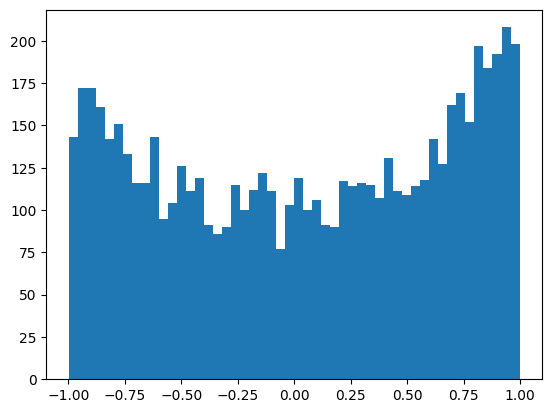

In [42]:
plt.hist(h.view(-1).tolist(),50);

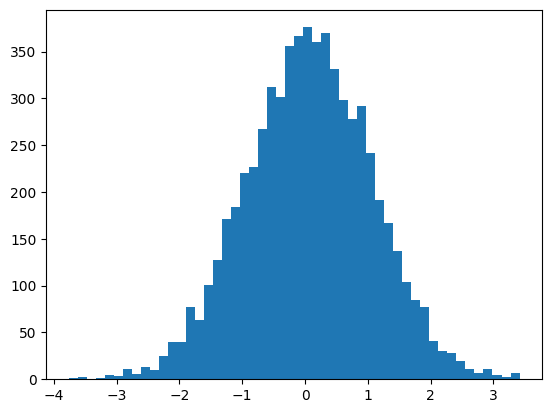

In [43]:
plt.hist(hpreact.view(-1).tolist(),50);

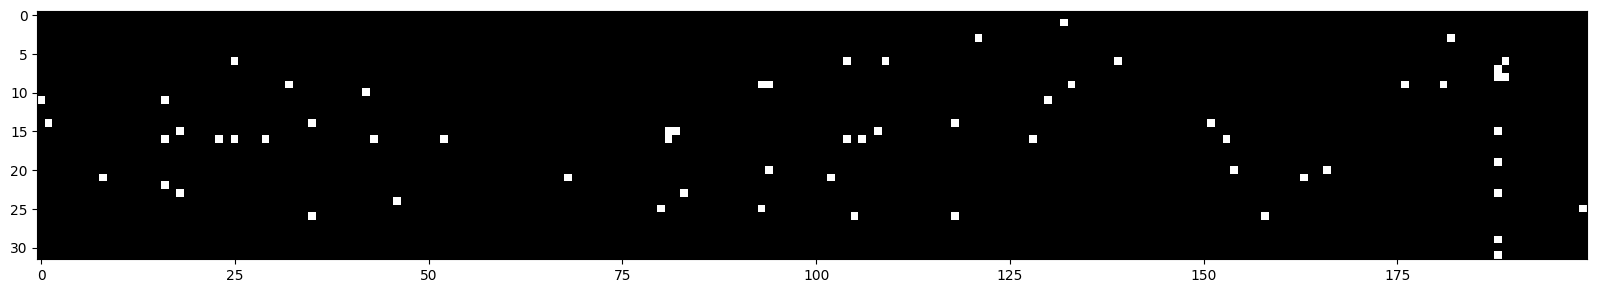

In [44]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99, cmap="gray", interpolation="nearest") #no white! scaling down w1 and b1 fixed it!

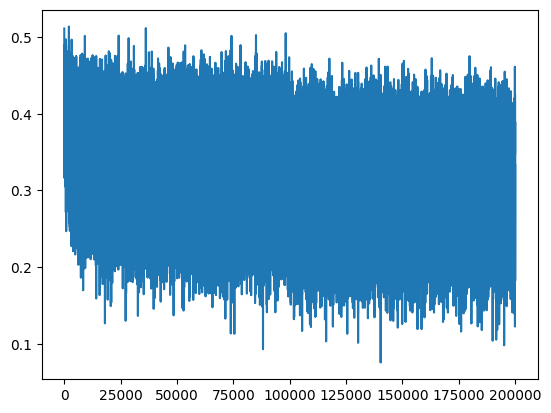

In [46]:
plt.plot(lossi)

In [47]:
@torch.no_grad() #disable gradient tracking. 
def split_loss(split):
    x,y = {
        'train': (Xtr,Ytr),
        'val': (Xdev,Ydev),
        'test': (Xte,Yte)
    }[split]
    emb = C[x]#(N, block_size, n_embd)
    embcat = emb.view(emb.shape[0],-1) #concatenate into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1) # (N, Nhidden)
    logits = h @ W2 + b2 # (N, vocab_size) 
    loss = F.cross_entropy(logits,y)
    print(split,loss.item())

split_loss('train')
split_loss('val')


train 2.0366742610931396
val 2.1033573150634766


In [ ]:
#this is illustrating init and its impacts on performance. This wasn't so bad for this particular network cuz its simple, but a more complex network can sometimes just
# not even train if its initialization is bad. 
# 
# before making our init better we had:
#  train 2.1269264221191406
# val 2.171828031539917. now, as you can see directly above, its much better

In [48]:
#sample from model 
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # init with all
    while True:
        #Forward pass the NN
        emb = C[torch.tensor([context])] # (1, block_size, n_embd)
        h = torch.tanh(emb.view(1,-1) @ W1+b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim = 1)
        #sample from dist
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        #shift the context window and track samples
        context = context[1:]+ [ix]
        out.append(ix)
        #if we sample the special "." token, break
        if ix == 0:
            break
    print(''.join(itos[i]for i in out))

carmahzailyn.
kit.
jarri.
thil.
skanden.
jazhinn.
delynn.
jareei.
nellara.
chaily.
kaleigh.
ham.
joce.
quint.
saline.
liven.
arrothogdifryn.
kai.
eulissa.
med.


In [ ]:
#This approach is kind of nuts, we have more magic numbers scaling our weights and biases, they're not calculated. it can be done properly.

#kaiming initialisation is a way to properly scale our initial normally distributed weight and bias matrices. if we leave them unscaled then the standard distributions will change 
#as we go through mat muls and whatnot. the exact number we have to scale our initialisation weights and biases by is our "gain"/sqrt(fan_in).
#The best "gain" to use depends on what kind of nonlinearity you're using. After all, its a compensating factor for how much our nonlinearity function "squishes" the normal distribution.
#It's described here: https://pytorch.org/docs/stable/nn.init.html
#In our case, we're using TanH, so its 5/3. 

In [7]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * ((5/3) / (n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 #scaling W2 down at init to prevent first iter logits from being too high
b2 = torch.randn(vocab_size,                      generator=g) * 0 #setting b2 to be 0 at initialization to prevent first iter logits from going nuts


parameters = [C, W1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11697


In [8]:
#Dame optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    #minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    Xb,Yb = Xtr[ix], Ytr[ix] #batch X,Y
    #Forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0],-1) #concatenate the vectors 
    hpreact = embcat @ W1 + b1 #hidden layer preactivation
    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2 #output layer 
    loss = F.cross_entropy(logits,Yb)

    #Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update 
    lr = 0.1 if i < 100000 else 0.01 #step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    #track stats 
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    #break


      0/ 200000: 3.3179
  10000/ 200000: 2.1928
  20000/ 200000: 2.3333
  30000/ 200000: 2.5376
  40000/ 200000: 1.9618
  50000/ 200000: 2.3344
  60000/ 200000: 2.3849
  70000/ 200000: 2.1605
  80000/ 200000: 2.3181
  90000/ 200000: 2.2200
 100000/ 200000: 1.8285
 110000/ 200000: 2.1300
 120000/ 200000: 1.9468
 130000/ 200000: 2.3329
 140000/ 200000: 2.1031
 150000/ 200000: 2.1707
 160000/ 200000: 1.7701
 170000/ 200000: 1.7840
 180000/ 200000: 1.9529
 190000/ 200000: 1.8062


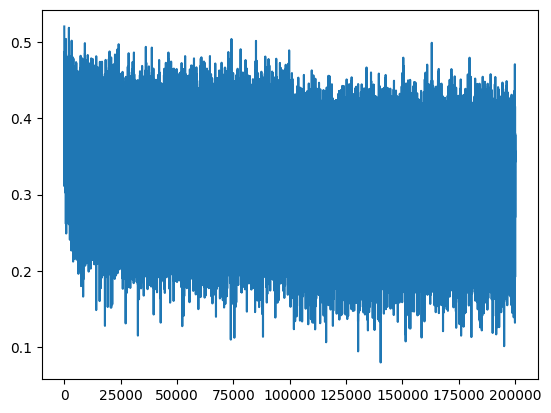

In [9]:
plt.plot(lossi)

In [10]:
@torch.no_grad() #disable gradient tracking. 
def split_loss(split):
    x,y = {
        'train': (Xtr,Ytr),
        'val': (Xdev,Ydev),
        'test': (Xte,Yte)
    }[split]
    emb = C[x]#(N, block_size, n_embd)
    embcat = emb.view(emb.shape[0],-1) #concatenate into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1) # (N, Nhidden)
    logits = h @ W2 + b2 # (N, vocab_size) 
    loss = F.cross_entropy(logits,y)
    print(split,loss.item())

split_loss('train')
split_loss('val')


train 2.03947377204895
val 2.109386682510376


In [ ]:
#It's basically the same, but importantly, we don't have arbitrary numbers being chosen, this is more principled and can be scaled.
#It's not as important as it was a decade ago, and this is because of some cool methods that make training generally more consistent. One of them is called Batch Normalization. Let's go.

In [12]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * ((5/3) / (n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 #scaling W2 down at init to prevent first iter logits from being too high
b2 = torch.randn(vocab_size,                      generator=g) * 0 #setting b2 to be 0 at initialization to prevent first iter logits from going nuts

bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))
#Above, we're initializing bngain and bnbias as learnable parameters to properly gaussian'ize our lovely matrices.
parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [13]:
#Dame optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    #minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    Xb,Yb = Xtr[ix], Ytr[ix] #batch X,Y
    #Forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0],-1) #concatenate the vectors 
    hpreact = embcat @ W1 + b1 #hidden layer preactivation
    hpreact = bngain * ((hpreact - hpreact.mean(0,keepdim=True)) / hpreact.std(0,keepdim=True)) + bnbias
    # Performs batch normalization on the tensor `hpreact`:
# 1. Subtracts the mean of `hpreact` (calculated across the batch, keeping dimensions for broadcasting)
#    to center the data around zero.
# 2. Divides the centered values by their standard deviation (also calculated across the batch),
#    standardizing the data to have zero mean and unit variance.
# 3. Scales the normalized values by `bngain`, a learnable parameter, allowing the network to control
#    the output's range.
# 4. Shifts the scaled values by `bnbias`, another learnable parameter, allowing the network to adjust
#    the mean of the output.
# This ensures stable training by normalizing activations while retaining flexibility through learnable
# scaling and shifting parameters.
    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2 #output layer 
    loss = F.cross_entropy(logits,Yb)

    #Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update 
    lr = 0.1 if i < 100000 else 0.01 #step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    #track stats 
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    #break


      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


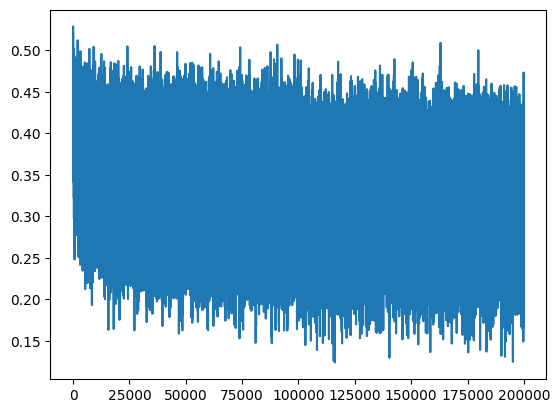

In [15]:
plt.plot(lossi)

In [14]:
@torch.no_grad() #disable gradient tracking. 
def split_loss(split):
    x,y = {
        'train': (Xtr,Ytr),
        'val': (Xdev,Ydev),
        'test': (Xte,Yte)
    }[split]
    emb = C[x]#(N, block_size, n_embd)
    embcat = emb.view(emb.shape[0],-1) #concatenate into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * ((hpreact - hpreact.mean(0,keepdim=True)) / hpreact.std(0,keepdim=True)) + bnbias
    h = torch.tanh(hpreact) # (N, Nhidden)
    logits = h @ W2 + b2 # (N, vocab_size) 
    loss = F.cross_entropy(logits,y)
    print(split,loss.item())

split_loss('train')
split_loss('val')


train 2.0668270587921143
val 2.104844808578491


In [ ]:
#This batchnorm has some strange effects. the batches are mathematically connected to eachother in the computational graph now. that's not great
#the benefit is that it also happens to act as some kind of regulariser. this is explained below:

# How Batch Normalization Acts as a Regularizer

Batch normalization (BatchNorm) can act as a **regularizer** in deep learning models by mitigating overfitting, even when no explicit regularization techniques like dropout or weight decay are applied. This behavior arises primarily due to the noise introduced during training and its influence on the optimization landscape.

## **Mechanisms of Regularization with BatchNorm**

### 1. Stochastic Noise During Training
- During training, BatchNorm calculates the mean and variance of each batch to normalize activations. Since batches are random subsets of data, the computed statistics vary slightly from batch to batch.
- This randomness introduces **stochastic noise** into the training process, acting similarly to other regularization methods by preventing the model from overfitting to specific training examples.

### 2. Smoothing the Loss Landscape
- By normalizing activations, BatchNorm ensures that they remain in a stable range. This stabilization allows the loss surface to become smoother and prevents sharp, narrow minima that are often associated with overfitting.
- Models trained with smoother loss surfaces generalize better to unseen data.

### 3. Implicit Parameter Constraints
- BatchNorm introduces learnable parameters, such as the scale (`gamma`) and shift (`beta`) factors, that adjust the normalized outputs. These parameters constrain the network's ability to learn overly complex mappings for the data, indirectly reducing the model's capacity to memorize noise or outliers.

### 4. Reduced Sensitivity to Initialization and Hyperparameters
- By normalizing activations, BatchNorm reduces the dependency on precise weight initialization and learning rates. This robustness makes the training process more stable and less likely to overfit due to poor initialization.

### 5. Decorrelation of Features
- Normalizing activations reduces the covariance between features, a phenomenon known as **covariate shift**. This reduction discourages the model from developing co-adaptations among neurons, which can lead to overfitting in the absence of regularization.

## **Empirical Observations**
In practice, BatchNorm's regularization effect is often observed when:
- Training without explicit regularizers still results in strong generalization.
- Models with BatchNorm perform better on validation and test sets compared to those trained without it.

## **Conclusion**
While BatchNorm inherently provides regularization, combining it with explicit methods like dropout or weight decay can still be beneficial, especially in very large models or when data is limited. BatchNorm acts as a regularizer by:
- Introducing noise through batch-wise statistics.
- Smoothing the optimization process.
- Implicitly constraining the model's capacity to overfit.

These effects make BatchNorm a powerful tool for improving generalization in deep learning.


In [ ]:
#How do we feed in single examples for inference? With this batchnorm stuff, our model now expects a batch as an input during a forward pass? weird

In [6]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * ((5/3) / (n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 #scaling W2 down at init to prevent first iter logits from being too high
b2 = torch.randn(vocab_size,                      generator=g) * 0 #setting b2 to be 0 at initialization to prevent first iter logits from going nuts

bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))
#Above, we're initializing bngain and bnbias as learnable parameters to properly gaussian'ize our lovely matrices.
parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [7]:
#Dame optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    #minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    Xb,Yb = Xtr[ix], Ytr[ix] #batch X,Y
    #Forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0],-1) #concatenate the vectors 
    hpreact = embcat @ W1 + b1 #hidden layer preactivation
    hpreact = bngain * ((hpreact - hpreact.mean(0,keepdim=True)) / hpreact.std(0,keepdim=True)) + bnbias
    # Performs batch normalization on the tensor `hpreact`:
# 1. Subtracts the mean of `hpreact` (calculated across the batch, keeping dimensions for broadcasting)
#    to center the data around zero.
# 2. Divides the centered values by their standard deviation (also calculated across the batch),
#    standardizing the data to have zero mean and unit variance.
# 3. Scales the normalized values by `bngain`, a learnable parameter, allowing the network to control
#    the output's range.
# 4. Shifts the scaled values by `bnbias`, another learnable parameter, allowing the network to adjust
#    the mean of the output.
# This ensures stable training by normalizing activations while retaining flexibility through learnable
# scaling and shifting parameters.
    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2 #output layer 
    loss = F.cross_entropy(logits,Yb)

    #Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update 
    lr = 0.1 if i < 100000 else 0.01 #step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    #track stats 
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    #break


      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


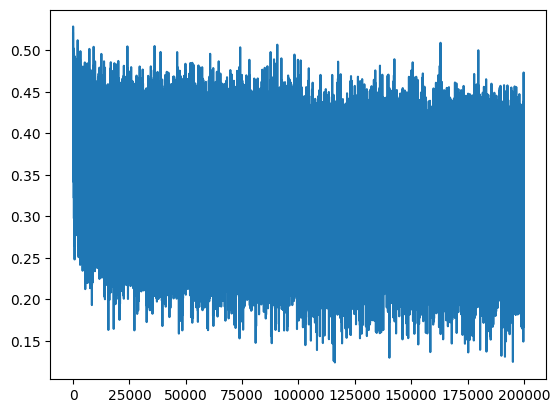

In [8]:
plt.plot(lossi)

In [10]:
#Calibrate the batchnorm at the end of training! 

with torch.no_grad():
    #pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ W1 + b1
    #measure the mean/std over the entire training set
    bnmean = hpreact.mean(0,keepdim=True)
    bnstd = hpreact.std(0,keepdim=True)

In [11]:
#Now, when calculating our losses, instead of dynamically calculating our standard deviation for our batch norm calculation, we'll just use the calculated values
#for the entire training set
@torch.no_grad() #disable gradient tracking. 
def split_loss(split):
    x,y = {
        'train': (Xtr,Ytr),
        'val': (Xdev,Ydev),
        'test': (Xte,Yte)
    }[split]
    emb = C[x]#(N, block_size, n_embd)
    embcat = emb.view(emb.shape[0],-1) #concatenate into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    #hpreact = bngain * ((hpreact - hpreact.mean(0,keepdim=True)) / hpreact.std(0,keepdim=True)) + bnbias
    hpreact = bngain * ((hpreact - bnmean) / bnstd) + bnbias

    h = torch.tanh(hpreact) # (N, Nhidden)
    logits = h @ W2 + b2 # (N, vocab_size) 
    loss = F.cross_entropy(logits,y)
    print(split,loss.item())

split_loss('train')
split_loss('val')


train 2.0668270587921143
val 2.1049270629882812


In [ ]:
#We get the same kind of result, but we can now feed in single examples as our input tensors for the std and mean are now fixed
#Basically nobody wants to go through the step of calculating this stuff after training, so we just do it in training like this:

In [13]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * ((5/3) / (n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 #scaling W2 down at init to prevent first iter logits from being too high
b2 = torch.randn(vocab_size,                      generator=g) * 0 #setting b2 to be 0 at initialization to prevent first iter logits from going nuts

bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))
bnmean_running = torch.zeros((1,n_hidden))
bnstd_running = torch.ones((1,n_hidden))
#Above, we're initializing bngain and bnbias as learnable parameters to properly gaussian'ize our lovely matrices.
parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [ ]:
#What's happening below is that while we're training below, we are keeping track of the mean and std and estimating them once, outside the computation
#graph.

In [14]:
#Dame optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    #minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    Xb,Yb = Xtr[ix], Ytr[ix] #batch X,Y
    #Forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0],-1) #concatenate the vectors 
    hpreact = embcat @ W1 + b1 #hidden layer preactivation
    bnmean_i = hpreact.mean(0,keepdim=True)
    bnstd_i = hpreact.std(0,keepdim=True)
    hpreact = bngain * (hpreact - bnmean_i) / bnstd_i + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmean_i
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstd_i
    # Performs batch normalization on the tensor `hpreact`:
# 1. Subtracts the mean of `hpreact` (calculated across the batch, keeping dimensions for broadcasting)
#    to center the data around zero.
# 2. Divides the centered values by their standard deviation (also calculated across the batch),
#    standardizing the data to have zero mean and unit variance.
# 3. Scales the normalized values by `bngain`, a learnable parameter, allowing the network to control
#    the output's range.
# 4. Shifts the scaled values by `bnbias`, another learnable parameter, allowing the network to adjust
#    the mean of the output.
# This ensures stable training by normalizing activations while retaining flexibility through learnable
# scaling and shifting parameters.
    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2 #output layer 
    loss = F.cross_entropy(logits,Yb)

    #Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update 
    lr = 0.1 if i < 100000 else 0.01 #step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    #track stats 
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    #break


      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


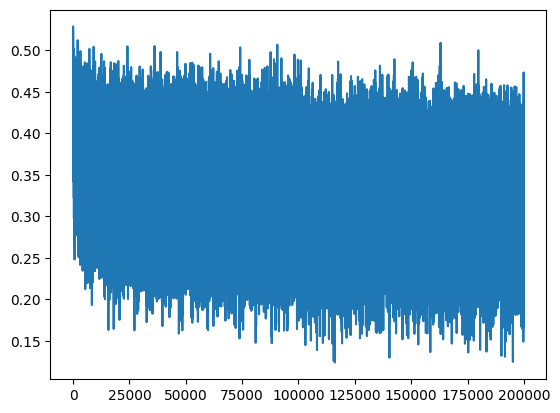

In [15]:
plt.plot(lossi)

In [16]:
#we'll do the explicit estimating this time only, purely so we can see that they're similar to the ones we're doing alongside the training.
#in production, we don't have to do this. 
#Calibrate the batchnorm at the end of training! 

with torch.no_grad():
    #pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ W1 + b1
    #measure the mean/std over the entire training set
    bnmean = hpreact.mean(0,keepdim=True)
    bnstd = hpreact.std(0,keepdim=True)

In [17]:
bnmean

tensor([[-2.3355,  0.6776, -0.9133,  1.0163,  1.0866,  1.0938,  1.7437, -2.1208,
          0.5730,  1.4455, -1.6343, -2.7372, -0.4752, -0.1412, -0.0745, -1.1722,
          0.6851, -2.6219, -0.1065,  1.6326, -0.7706, -0.3062,  0.0479,  0.6115,
          1.1173,  0.2427,  2.0500,  0.5831,  0.8527,  1.7680, -0.3625, -0.8356,
         -0.0854, -0.5177, -0.3806, -1.0699, -0.0786,  0.3487, -0.5808,  0.9875,
         -0.4427, -1.3082, -0.2871, -0.2332,  0.6850,  0.6850,  2.0857, -0.7608,
          2.3866,  1.8734,  0.8259,  0.2803,  1.8897,  0.4709,  0.6739, -1.8940,
         -0.0401,  0.4338,  1.3760, -0.8910, -0.4524,  1.1754,  0.5613,  0.6051,
          1.5859,  1.2260, -1.0111,  2.1495, -0.6393,  0.0938, -0.2864, -0.4856,
          0.9632, -1.0461, -2.9990,  0.6391,  1.4327, -0.1590,  0.0941,  0.5253,
          0.2508,  1.2521,  2.0388,  0.6608,  0.0691, -0.0813, -1.6723,  0.2933,
          2.2423, -0.0211, -0.6666,  1.4253, -0.8412, -1.2248, -1.0129,  0.2230,
          0.2113, -0.3226,  

In [18]:
bnmean_running

tensor([[-2.3539,  0.6872, -0.9001,  1.0159,  1.0894,  1.0862,  1.7389, -2.1357,
          0.5608,  1.4246, -1.6445, -2.7426, -0.4861, -0.1510, -0.0687, -1.1550,
          0.6891, -2.6399, -0.1283,  1.6240, -0.7732, -0.2864,  0.0467,  0.6119,
          1.1172,  0.2433,  2.0542,  0.5778,  0.8515,  1.7729, -0.3741, -0.8385,
         -0.0831, -0.5198, -0.3817, -1.0698, -0.0781,  0.3370, -0.5768,  0.9935,
         -0.4507, -1.3313, -0.2895, -0.2298,  0.6877,  0.6936,  2.0835, -0.7759,
          2.3804,  1.8613,  0.8117,  0.2735,  1.8802,  0.4705,  0.6656, -1.8962,
         -0.0420,  0.4356,  1.3924, -0.8906, -0.4676,  1.1688,  0.5539,  0.6001,
          1.5853,  1.2103, -1.0171,  2.1422, -0.6330,  0.1071, -0.2926, -0.4831,
          0.9506, -1.0144, -2.9925,  0.6268,  1.4404, -0.1574,  0.0955,  0.5159,
          0.2487,  1.2400,  2.0104,  0.6695,  0.0768, -0.0851, -1.6768,  0.2963,
          2.2374, -0.0100, -0.6670,  1.4356, -0.8431, -1.2317, -1.0220,  0.2201,
          0.1929, -0.3261,  

In [19]:
bnstd

tensor([[2.3929, 2.1364, 2.2663, 1.9944, 2.1860, 2.3736, 2.2576, 2.3451, 2.3578,
         2.1045, 2.4973, 2.2571, 2.1519, 2.2017, 2.0989, 2.7105, 2.4423, 1.8902,
         2.2073, 2.5144, 2.3232, 2.3402, 2.1268, 2.0214, 2.0374, 1.8407, 2.1634,
         2.6021, 2.2403, 2.3329, 1.7083, 1.9046, 2.0957, 1.8207, 2.0848, 1.9323,
         2.4885, 2.1671, 2.1170, 1.8611, 2.0108, 2.0911, 2.4064, 1.9754, 1.9694,
         2.4172, 2.1965, 2.5617, 2.1547, 2.4972, 2.0511, 1.8491, 2.0182, 1.7755,
         2.3971, 2.2095, 1.7725, 2.2930, 2.5639, 1.7747, 2.1165, 1.9382, 2.0266,
         2.2968, 2.1514, 2.3390, 2.1540, 2.4904, 2.0355, 2.1785, 2.0923, 1.9757,
         1.9921, 2.2562, 1.9101, 1.8626, 2.5723, 2.2043, 1.6819, 2.2513, 2.0126,
         1.8353, 2.0170, 2.2116, 2.5047, 2.3529, 2.1391, 2.3848, 2.5823, 2.6848,
         2.0914, 1.9556, 2.1099, 1.9680, 1.8658, 2.2201, 2.1905, 2.0695, 1.8927,
         2.3433, 2.0515, 2.1435, 2.2730, 2.0000, 1.9994, 2.2908, 1.8655, 2.2061,
         1.9252, 2.1527, 2.3

In [20]:
bnstd_running

tensor([[2.3689, 2.0998, 2.2499, 1.9599, 2.1515, 2.3429, 2.2431, 2.3104, 2.3309,
         2.0823, 2.4680, 2.2253, 2.1192, 2.1805, 2.0655, 2.6865, 2.4191, 1.8718,
         2.1882, 2.4989, 2.2903, 2.3144, 2.1068, 1.9938, 2.0172, 1.8189, 2.1352,
         2.5721, 2.2250, 2.3027, 1.6857, 1.8987, 2.0912, 1.8024, 2.0771, 1.9073,
         2.4760, 2.1356, 2.0873, 1.8440, 1.9877, 2.0603, 2.3704, 1.9412, 1.9464,
         2.4033, 2.1706, 2.5047, 2.1319, 2.4826, 2.0177, 1.8196, 1.9937, 1.7548,
         2.3758, 2.1857, 1.7500, 2.2775, 2.5494, 1.7520, 2.0970, 1.9272, 2.0154,
         2.2870, 2.1270, 2.3166, 2.1311, 2.4586, 2.0074, 2.1553, 2.0607, 1.9618,
         1.9790, 2.2358, 1.8885, 1.8480, 2.5581, 2.1731, 1.6619, 2.2316, 1.9924,
         1.8106, 1.9824, 2.1808, 2.4859, 2.3152, 2.1121, 2.3617, 2.5755, 2.6760,
         2.0648, 1.9299, 2.1034, 1.9445, 1.8592, 2.1894, 2.1640, 2.0496, 1.8632,
         2.3143, 2.0495, 2.1165, 2.2337, 1.9762, 1.9748, 2.2615, 1.8477, 2.1645,
         1.9084, 2.1207, 2.3

In [ ]:
#Now, when calculating our losses, instead of dynamically calculating our standard deviation for our batch norm calculation, we'll just use the calculated values
#for the entire training set

#Now we calculate our loss using our running mean and std. we've eliminated the need to explicitly do this post training using its own block of code
@torch.no_grad() #disable gradient tracking. 
def split_loss(split):
    x,y = {
        'train': (Xtr,Ytr),
        'val': (Xdev,Ydev),
        'test': (Xte,Yte)
    }[split]
    emb = C[x]#(N, block_size, n_embd)
    embcat = emb.view(emb.shape[0],-1) #concatenate into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    #hpreact = bngain * ((hpreact - hpreact.mean(0,keepdim=True)) / hpreact.std(0,keepdim=True)) + bnbias
    hpreact = bngain * ((hpreact - bnmean_running) / bnstd_running) + bnbias

    h = torch.tanh(hpreact) # (N, Nhidden)
    logits = h @ W2 + b2 # (N, vocab_size) 
    loss = F.cross_entropy(logits,y)
    print(split,loss.item())

split_loss('train')
split_loss('val')


train 2.066591501235962
val 2.1050572395324707


In [ ]:
#Note for the bottom line of code (do not run this, doofus):
#    hpreact = bngain * (hpreact - bnmean_i) / bnstd_i + bnbias
#In the bathnorm paper, there's a constant ε being added to bnstd_i, this is to avoid a division by 0, it can be a very small number so it's well behaved.
#It's astronomically unlikely we'll get a batch with 0 variance but like. it's something to consider. we won't do it here

In [ ]:
#Note for training (don't run this either). 
#Whenever we're running batchnorm layers, any bias in the previous layers is subtracted out. We're adding a bias b1. and calculating the mean of hpreact.
#This basically just adds the bias to the mean. but then we subtract the mean off the hpreact tensor anyway. so it gets added, then subtracted. 
#hpreact = embcat @ W1 + b1 #hidden layer preactivation
#bnmean_i = hpreact.mean(0,keepdim=True)
#bnstd_i = hpreact.std(0,keepdim=True)
#hpreact = bngain * (hpreact - bnmean_i) / bnstd_i + bnbias

#we're basically better off just not including b1 and just let bnbias do the bias'ing for our distribution. the BN layer has its own bias, theres no need to have a bias 
#in the layer before it. 

In [ ]:
#Clean up code: ---------------------------

In [29]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [30]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6414
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0199
 190000/ 200000: 2.1707


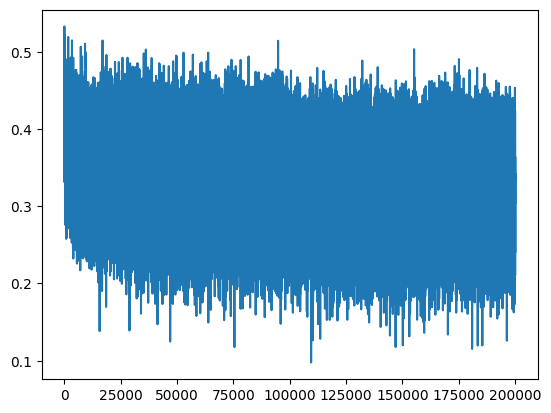

In [31]:
plt.plot(lossi)

In [32]:
# calibrate the batch norm at the end of training (This won't actually do anything when we calculate our validation loss and train loss and whatnot)

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [33]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0674145221710205
val 2.1056838035583496


In [ ]:
#it's common to throw in bathnorm layers after layers in which we do multiplication, like a linear layer or a conv layer. 

In [ ]:
#Stats that karpathy had below. the point is that we're improving

loss log
original:
train 2.1245384216308594 val 2.168196439743042

fix softmax confidently wrong:
train 2.07 val 2.13

fix tanh layer too saturated at init:
train 2.0355966091156006 val 2.1026785373687744

use semi-principled "kaiming init" instead of hacky init:
train 2.0376641750335693 val 2.106989622116089

add batch norm layer
train 2.0668270587921143 val 2.104844808578491

In [ ]:
#Let's PyTorch'ify it!

In [ ]:
#SUMMARY --------

In [34]:
#Let's train a deeper network and pytorch'ify it a lil bit
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

In [35]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [36]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2870


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.78%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.56%
layer 8 (      Tanh): mean -0.00, std 0.65, saturated: 2.25%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.69%
layer 14 (      Tanh): mean +0.00, std 0.65, saturated: 1.88%


Text(0.5, 1.0, 'activation distribution')

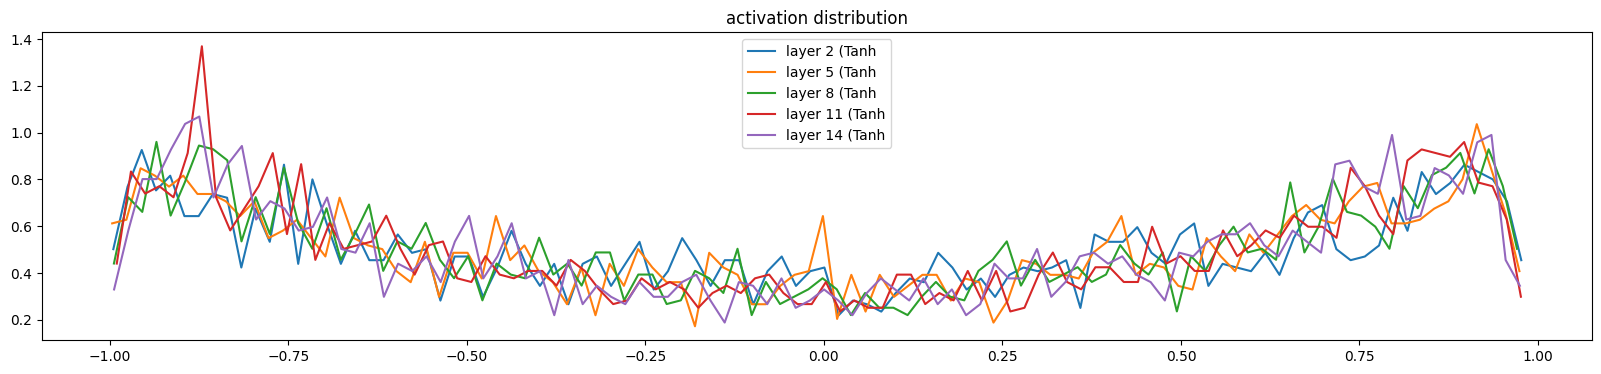

In [ ]:
# visualize histograms
# visualising the histograms of the forward pass activations at the Tanh layers. Iterating over all the layers except the outlayer.bias
#
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 2.640702e-03
layer 5 (      Tanh): mean -0.000000, std 2.245584e-03
layer 8 (      Tanh): mean +0.000000, std 2.045742e-03
layer 11 (      Tanh): mean -0.000000, std 1.983134e-03
layer 14 (      Tanh): mean -0.000000, std 1.952382e-03


Text(0.5, 1.0, 'gradient distribution')

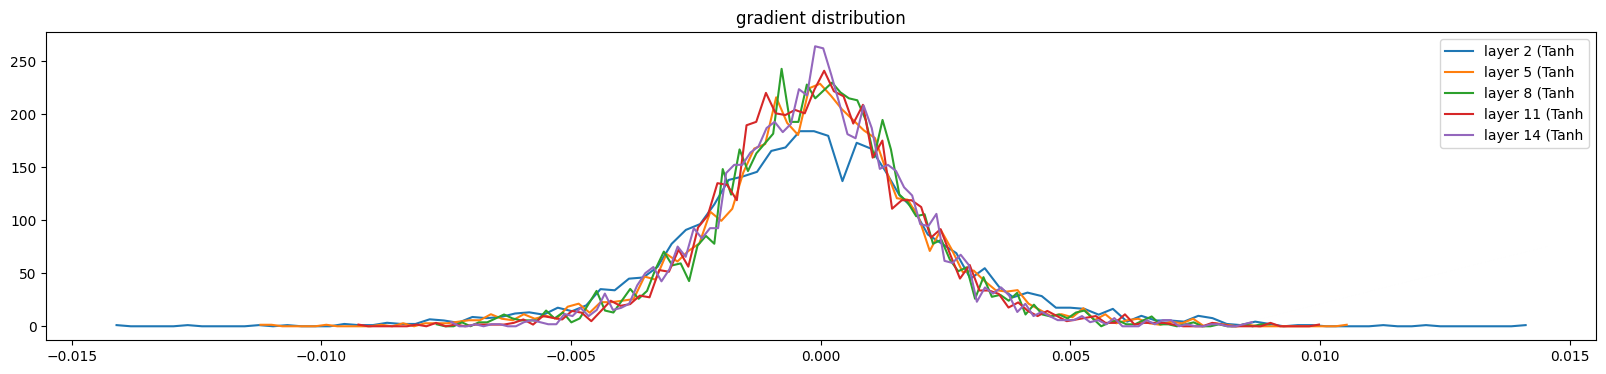

In [38]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 8.020533e-03 | grad:data ratio 8.012629e-03
weight  (30, 100) | mean +0.000246 | std 9.241072e-03 | grad:data ratio 4.881088e-02
weight (100, 100) | mean +0.000113 | std 7.132874e-03 | grad:data ratio 6.964615e-02
weight (100, 100) | mean -0.000086 | std 6.234300e-03 | grad:data ratio 6.073736e-02
weight (100, 100) | mean +0.000052 | std 5.742186e-03 | grad:data ratio 5.631481e-02
weight (100, 100) | mean +0.000032 | std 5.672204e-03 | grad:data ratio 5.570124e-02
weight  (100, 27) | mean -0.000082 | std 1.209416e-02 | grad:data ratio 1.160106e-01


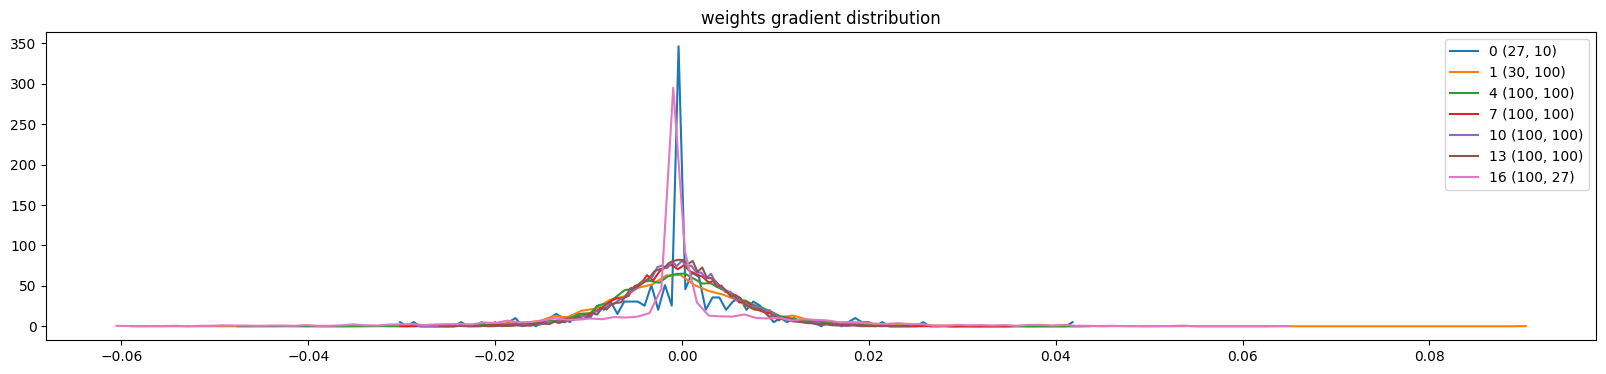

In [39]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

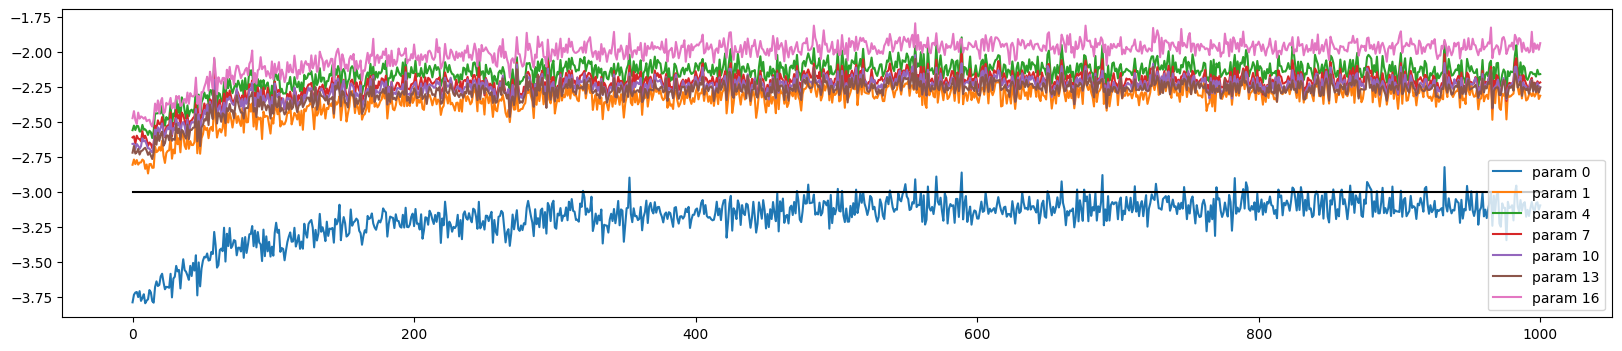

In [40]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);